In [1]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomAffine, RandomHorizontalFlip
from torchvision.transforms import InterpolationMode
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262)

transform_train_proper = Compose([
    ToTensor(),
])

transform_train_blurred = Compose([
    ToTensor(),
    Resize((8, 5), interpolation=InterpolationMode.BILINEAR, antialias=None),
    Resize((32, 18), interpolation=InterpolationMode.BILINEAR, antialias=None),
])

In [3]:
import math
from torch.utils.data import DataLoader, Dataset

class NormalizationDataset(Dataset):
    def __init__(self, dataset, transform1, transform2, overlap=0.5):
        self.dataset = dataset
        self.transform1 = transform1
        self.transform2 = transform2
        self.with_overlap = overlap / 2 + 0.5

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Split the image into two halves
        # print(type(image))
        width, height = image.size
        width_ = math.ceil(width * self.with_overlap)
        image1 = image.crop((0, 0, width_, height))
        image2 = image.crop((width-width_, 0, width, height))

        image1 = self.transform1(image1)
        image2 = self.transform2(image2)

        return image1, image2, label

In [4]:
import torch

class SplitAndAugmentDataset(Dataset):
    def __init__(self, dataset, transform1, transform2, overlap=0.5, is_train=True):
        self.dataset = dataset
        self.transform1 = transform1
        self.transform2 = transform2
        self.with_overlap = overlap / 2 + 0.5
        self.is_train = is_train
        print('overlap', self.with_overlap)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Split the image into two halves with overlap
        if self.is_train:
            if torch.rand(1) > 0.5:
                # reverse image horizontally
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
        width, height = image.size
        width_ = math.ceil(width * self.with_overlap)
        image1 = image.crop((0, 0, width_, height))
        image2 = image.crop((width-width_, 0, width, height))

        image1 = self.transform1(image1)
        image2 = self.transform2(image2)

        return image1, image2, label

In [9]:
import torchvision
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
dataset1 = NormalizationDataset(dataset, transform1=transform_train_proper, transform2=transform_train_blurred, overlap=0.125)

Files already downloaded and verified


In [ ]:
import numpy as np

x = np.stack([np.asarray(dataset[i][0]) for i in range(len(dataset))])
train_mean = np.mean(x, axis=(0, 2, 3))
train_std = np.std(x, axis=(0, 2, 3))

In [ ]:
train_mean, train_std

In [ ]:
import numpy as np

x = np.stack([np.asarray(dataset1[i][0]) for i in range(len(dataset))])
train_mean = np.mean(x, axis=(0, 2, 3))
train_std = np.std(x, axis=(0, 2, 3))

train_mean, train_std

In [6]:
import numpy as np

x = np.stack([np.asarray(dataset1[i][1]) for i in range(len(dataset))])
train_mean = np.mean(x, axis=(0, 2, 3))
train_std = np.std(x, axis=(0, 2, 3))

train_mean, train_std

(array([0.49126044, 0.48079324, 0.44522214], dtype=float32),
 array([0.21784401, 0.21501008, 0.23512621], dtype=float32))

In [7]:
import numpy as np
np.linspace(0, 200, 6)

array([  0.,  40.,  80., 120., 160., 200.])

In [ ]:
import numpy as np

x = np.stack([np.asarray(dataset1[i][1]) for i in range(len(dataset))])
train_mean = np.mean(x, axis=(0, 2, 3))
train_std = np.std(x, axis=(0, 2, 3))

train_mean, train_std

In [1]:
import torch
layers_dim = [3,32,64,128]

net2 = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Conv2d(layer_dim1, layer_dim2, 3, padding=1),
                                torch.nn.BatchNorm2d(layer_dim2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(layer_dim2, layer_dim2, 3, padding=1),
                                torch.nn.BatchNorm2d(layer_dim2),
                                torch.nn.ReLU(),
                                torch.nn.MaxPool2d(2, 2))
            for layer_dim1, layer_dim2 in zip(layers_dim[:-3], layers_dim[1:-2])
        ])

In [6]:
# get the output dimension of the last conv layer
x1 = net2[0](torch.randn(1, 3, 32, 32))

In [7]:
x1.device

device(type='cpu')

# Show dataset

In [1]:
from src.utils.prepare import prepare_loaders_clp

OVERLAP = 0.0
dataset_params = {'dataset_path': None, 'whether_aug': True, 'proper_normalization': True, 'overlap': OVERLAP}
loader_params = {'batch_size': 8, 'pin_memory': True, 'num_workers': 8}

loaders = prepare_loaders_clp('dual_cifar10', dataset_params=dataset_params, loader_params=loader_params)

Files already downloaded and verified
overlap: 0.0 with_overlap: 0.5
Files already downloaded and verified
overlap: 0.0 with_overlap: 0.5
Files already downloaded and verified
overlap: 0.0 with_overlap: 0.5


In [2]:
#plot the images from loaders in grid
import torchvision
import numpy as np

import matplotlib.pyplot as plt
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



/raid/NFS_SHARE/home/bartlomiej.krzepkowski/miniconda3/envs/clp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


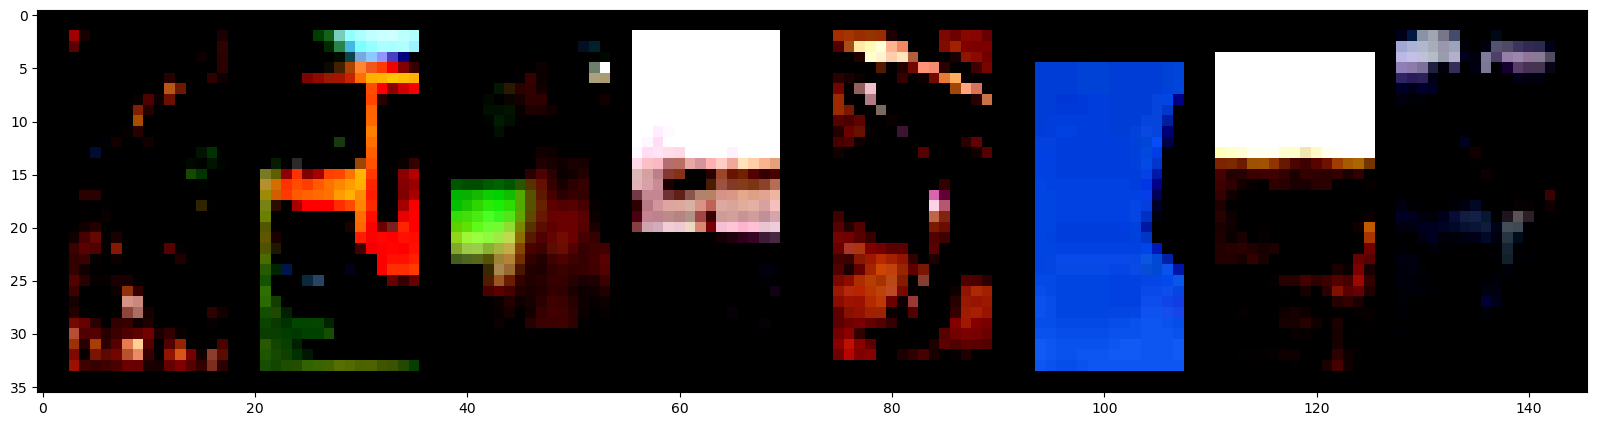

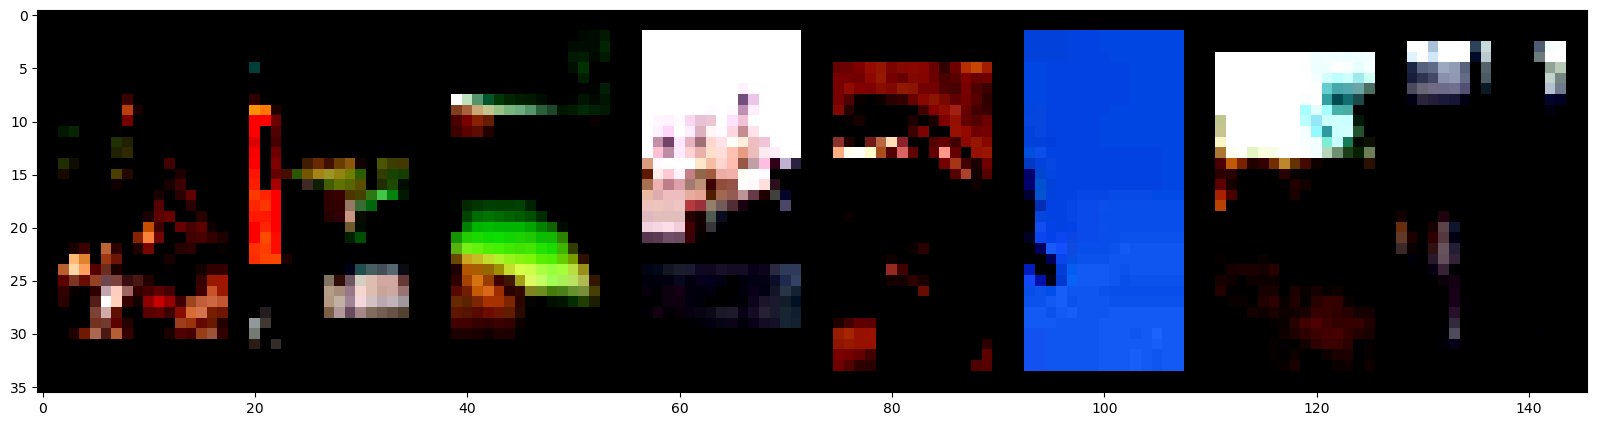

In [3]:
batch_left, batch_right, _ = next(iter(loaders['train']))
grid = torchvision.utils.make_grid(batch_left)
show(grid)
grid = torchvision.utils.make_grid(batch_right)
show(grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


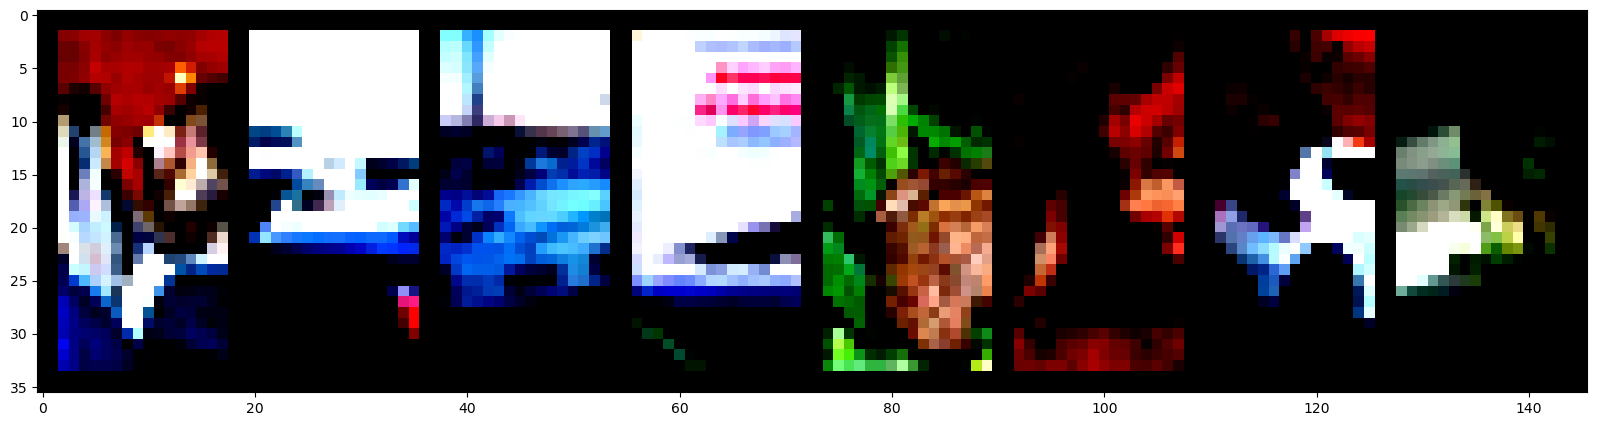

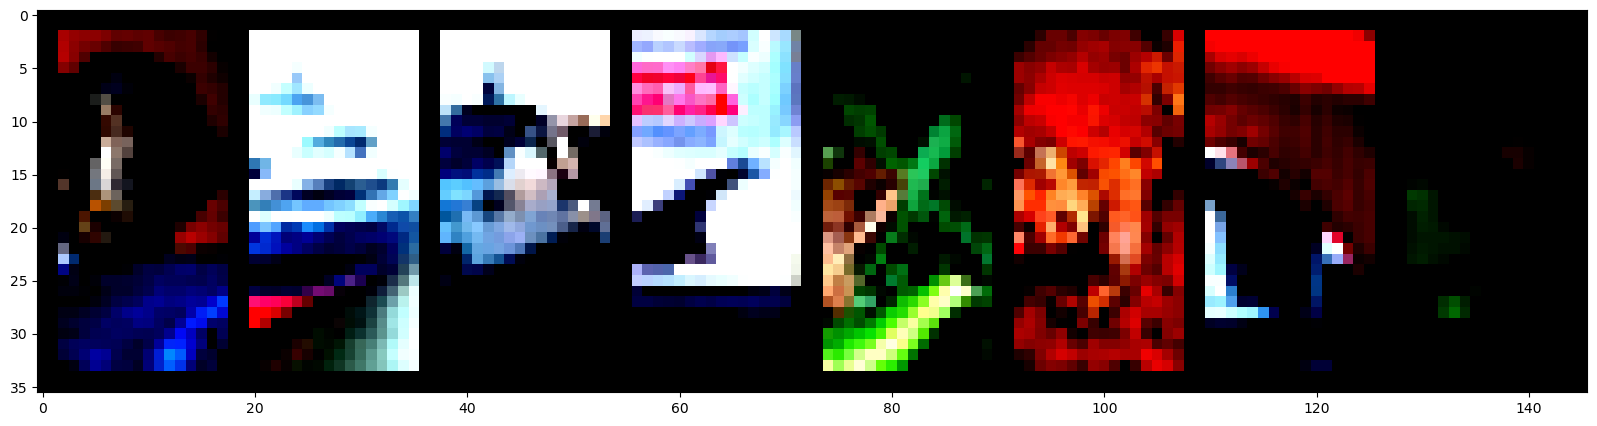

In [11]:
batch_left, batch_right, _ = next(iter(loaders['test_proper']))
grid = torchvision.utils.make_grid(batch_left)
show(grid)
grid = torchvision.utils.make_grid(batch_right)
show(grid)

In [24]:
np.random.seed(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


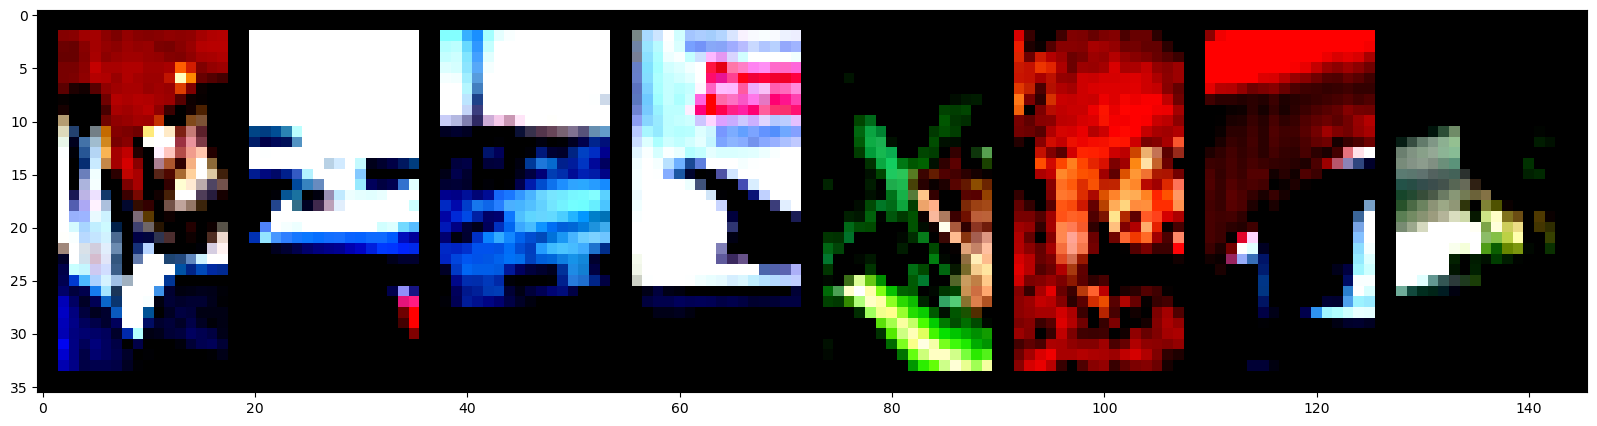

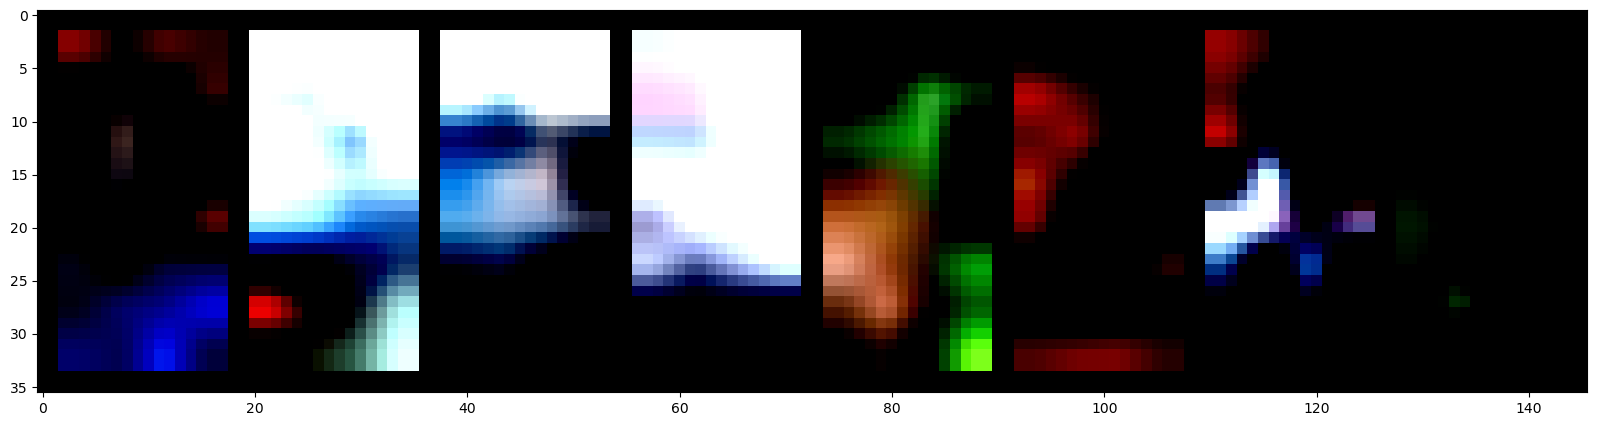

In [26]:
batch_left, batch_right, _ = next(iter(loaders['test_blurred']))
grid = torchvision.utils.make_grid(batch_left)
show(grid)
grid = torchvision.utils.make_grid(batch_right)
show(grid)

In [18]:
# get pil image
from PIL import Image
image = Image.open('pobrane.jpeg')
image.transpose(Image.FLIP_LEFT_RIGHT)
show(image)

AttributeError: numpy

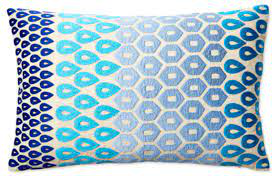

In [21]:
image = Image.open('pobrane.jpeg')
image

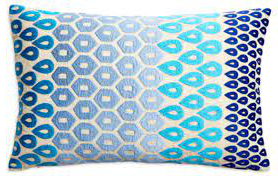

In [22]:
image.transpose(Image.FLIP_LEFT_RIGHT)

In [1]:
d = [2,3,1,3,6,3]

In [2]:
sorted(d)

[1, 2, 3, 3, 3, 6]

In [1]:
import numpy as np

In [2]:
np.linspace(120, 200, 3)

array([120., 160., 200.])